In [1]:
import matplotlib.pyplot as plt
import cv2
import os
from doctr.models import detection_predictor
import numpy as np
from copy import deepcopy
from typing import List
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from lines_segmentation.binarization import binarize

In [100]:
from statistics import mean
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter

In [2]:
model = detection_predictor(arch='db_resnet50', pretrained=True).eval()

def get_bboxes(img_path: str) -> List[tuple]:
    img = cv2.imread(img_path)
    out = model([img])
    h, w, _ = img.shape
    bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]
    return bboxes

/home/bekzat/anaconda3/envs/htr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
model = detection_predictor(arch='db_resnet50', pretrained=True).eval()

def get_bboxes(img_path: str) -> List[tuple]:
    img = cv2.imread(img_path)
    out = model([img])
    h, w, _ = img.shape
    bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]
    return bboxes

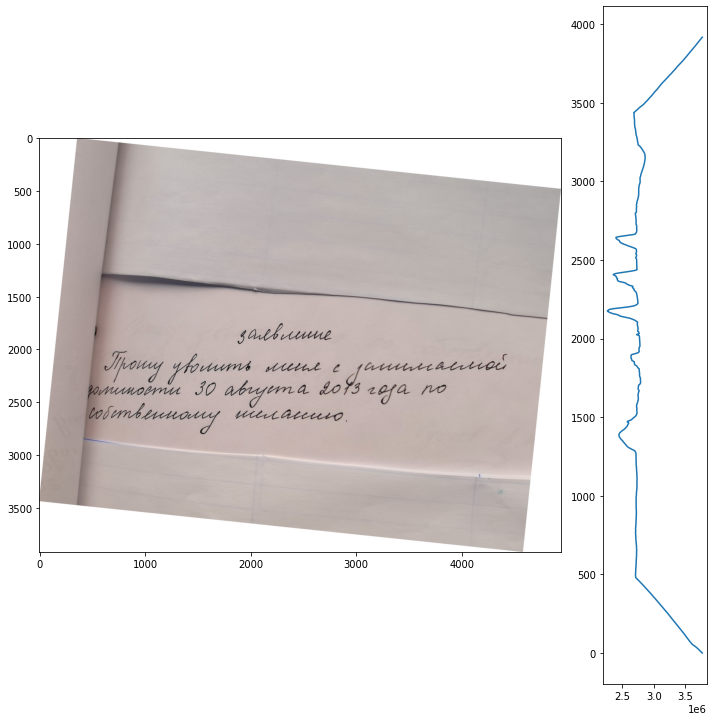

In [4]:
img = cv2.imread("/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg")

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()

ax[0].imshow(img)
projection = img.sum(axis=1).sum(axis=1)
ax[1].plot(projection,range(len(projection)))

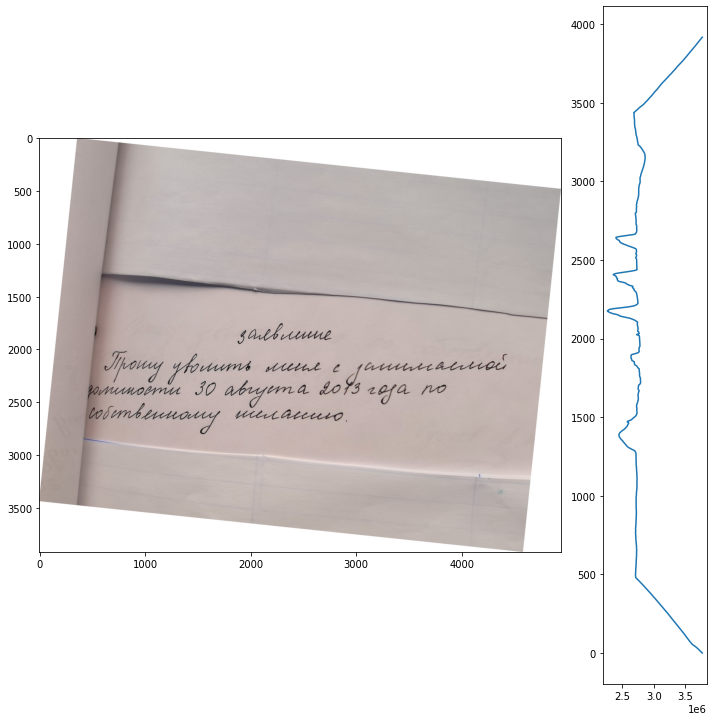

In [189]:
img = cv2.imread("/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg")

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()

ax[0].imshow(img)
projection = img.sum(axis=1).sum(axis=1)
ax[1].plot(projection,range(len(projection)))

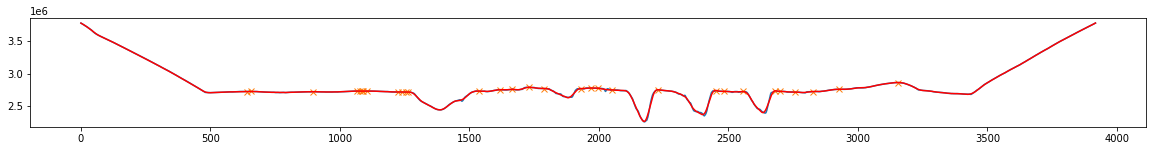

In [190]:
x = projection
xhat = savgol_filter(x, 61, 3)
peaks, _ = find_peaks(xhat, height=0)
plt.figure(figsize=(20, 2))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(xhat, color='red')
plt.show()

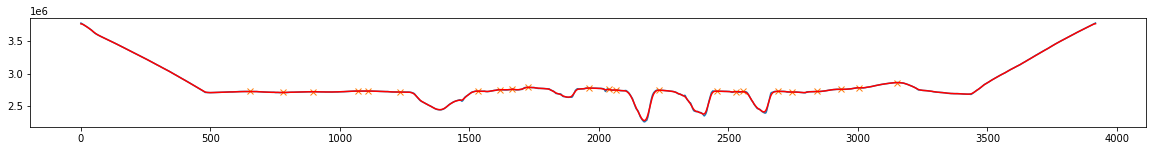

In [191]:
x = projection
xhat = gaussian_filter(x, sigma=7)
peaks, _ = find_peaks(xhat, height=0)
plt.figure(figsize=(20, 2))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(xhat, color='red')
plt.show()

# projection_smoothed = gaussian_filter(projection, sigma=7)

In [229]:
def prepare(img_path: str):
    bboxes = get_bboxes(img_path)

    max_x = max([bbox[2] for bbox in bboxes])
    min_x = min([bbox[0] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    img = cv2.imread(img_path)
    
    img = binarize(img)
    img = img[min_y:max_y, min_x:max_x]
    return bboxes, min_x, min_y, img

In [224]:
def find_separators(img: str, method: str):
    projection = img.sum(axis=1).sum(axis=1)
    if method == 'savgol':
        projection_smoothed = savgol_filter(projection, 70, 3)
        projection_smoothed = savgol_filter(projection_smoothed, 140, 3)
    else:
        projection_smoothed = gaussian_filter(projection, sigma=7)
    
    peaks, _ = find_peaks(projection_smoothed, height=0)
    return peaks, projection, projection_smoothed

In [225]:
def visualise_separators(img_path: str, method: str):
    bboxes = get_bboxes(img_path)

    max_x = max([bbox[2] for bbox in bboxes])
    min_x = min([bbox[0] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    img = cv2.imread(img_path)
    
    img = binarize(img)
    img = img[min_y:max_y, min_x:max_x]
    peaks, projection, projection_smoothed = find_separators(img, method)
    img_with_lines = deepcopy(img)
    for idx in peaks:
        cv2.line(img_with_lines, (0, idx), (img_with_lines.shape[1], idx), (255, 0, 0))

    for bbox in bboxes:
        img_with_lines = cv2.rectangle(img_with_lines, (bbox[0] - min_x, bbox[1] - min_y), (bbox[2] - min_x, bbox[3] - min_y), (0, 255, 0), 2)
    fig, ax = plt.subplots(2, 1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[0].imshow(img_with_lines)
    # ax.axis('off')
    ax[1].plot(projection)
    ax[1].plot(projection_smoothed, color='red')
#     save_path = "/home/bekzat/Beka/project_docreader/lising_with_bbox/" + path
#     fig.savefig(save_path)

In [230]:
def test(FILE_NAME: str):
    bboxes = get_bboxes(FILE_NAME)

    max_x = max([bbox[2] for bbox in bboxes])
    min_x = min([bbox[0] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    img = cv2.imread(FILE_NAME)

    img = img[min_y:max_y, min_x:max_x]
    image = binarize(img)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,3))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)
    
    kernel = np.ones((3,2),np.uint8)
    erosion = cv2.erode(thresh,kernel,iterations = 2)
    
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
    
    for i in range(0,3):
        canny = cv2.Canny(closing,0,255)
        closing = closing - canny
        
    out_inv = cv2.threshold(closing, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    out1 = draw_white_space_between_lines(out_inv,0,10000,True)
    out1 =cv2.threshold(out1, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(60,1))
    dilation1 = cv2.dilate(out1,kernel,iterations=7)

    contours, hierarchy = cv2.findContours(dilation1.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    img_1 = np.zeros([image.shape[0],image.shape[1],1],dtype=np.uint8)
    img_1.fill(255)

    cv2.drawContours(img_1, contours, -1, (0,0,255), 3, cv2.LINE_AA, hierarchy, 1 )
    projection = img_1.sum(axis=1).sum(axis=1)
    
#     projection_smoothed = savgol_filter(projection, 70, 3)
#     projection_smoothed_1 = savgol_filter(projection_smoothed, 140, 3)
    projection_smoothed = gaussian_filter(projection, sigma=7)
    
#     mean_peaks = mean(projection_smoothed)
#     minimum = [i for i in peaks if i > mean_peaks] 
    
    minimum = argrelextrema(projection_smoothed, np.less)[0]
    
    img_with_lines = deepcopy(image)
    
    for idx in minimum:
        cv2.line(img_with_lines, (0, idx), (img_with_lines.shape[1], idx), (255, 0, 0))
#     print(minimum)
    
    fig, ax = plt.subplots(2, 1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[0].imshow(img_with_lines)
    # ax.axis('off')
    ax[1].plot(projection)
    ax[1].plot(projection_smoothed, color='red')
    
    return

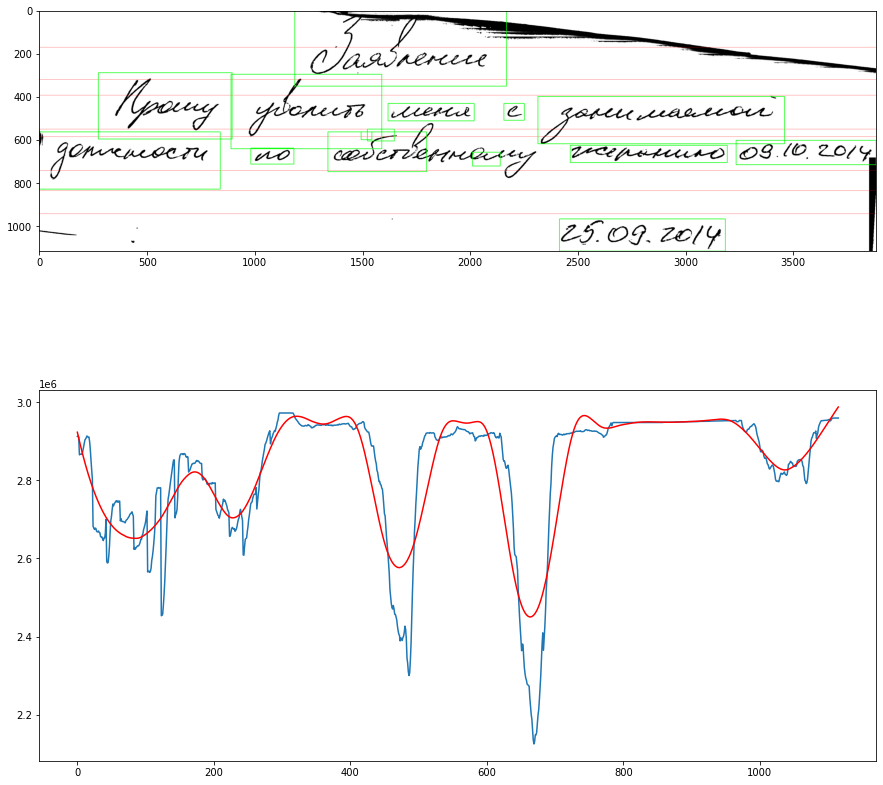

In [227]:
visualise_separators("/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_142405.jpg", method='savgol')

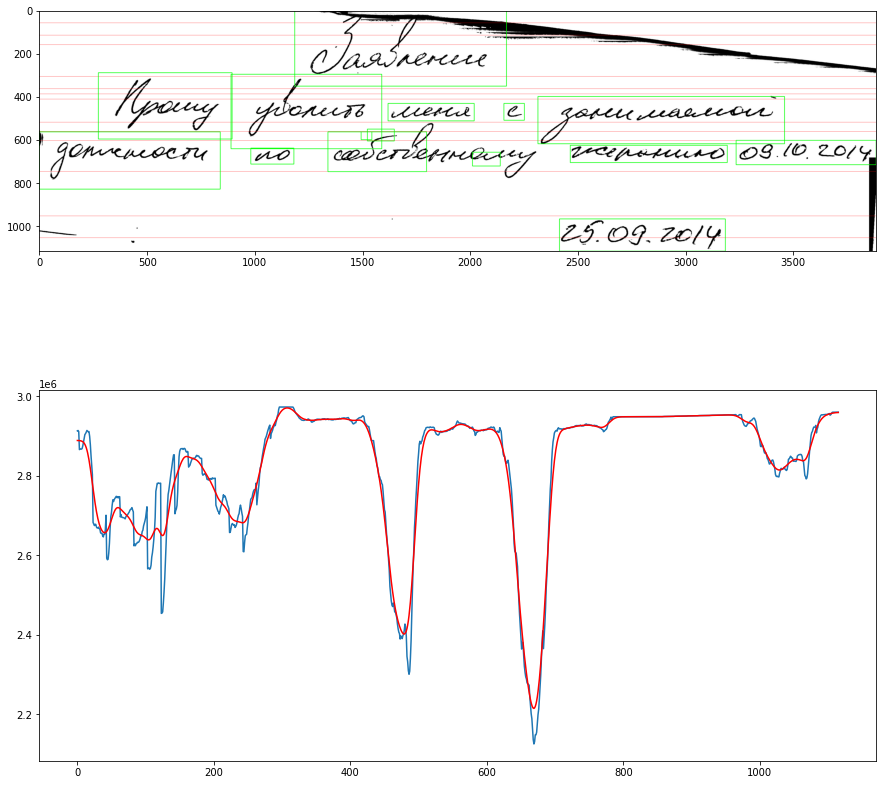

In [228]:
visualise_separators("/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_142405.jpg", method=None)

In [ ]:
visualise_separators("/home/bekzat/Beka/project_docreader/lising_rotate_10/IMG_20220425_142405.jpg")

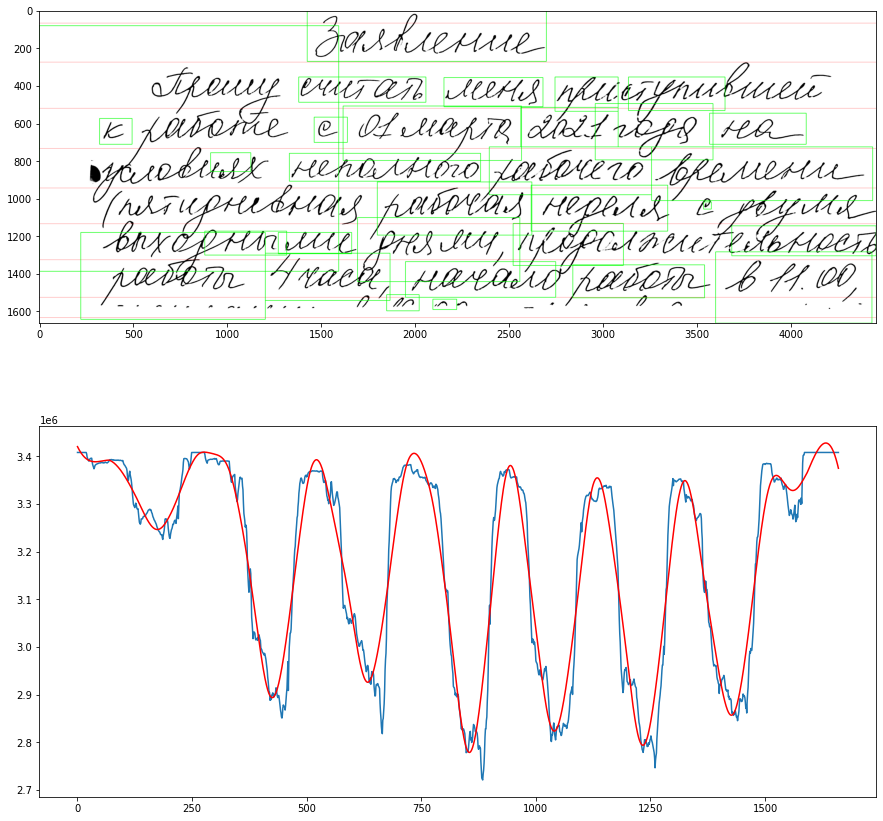

In [6]:
visualise_separators("/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_121720.jpg")

1) Поворачивать картинки из лизинга (выбрать интересные) 1, 3, 5, 7, 10 градусов
2) Исправлять повороты для рукописного текста
3) Находить маски для строк

In [29]:
def draw_white_space_between_lines(image, threshold_value_low=40000, threshold_value_high=40000, plot_histogram=False):
    h, w = image.shape[:2]
    gray = image.copy()
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#     thresh = gray
    # Sum white pixels in each row
    # Create blank space array and and final image
    pixels = np.sum(thresh, axis=1).tolist()
    space = np.ones((1, w), dtype=np.uint8) * 255
    result = np.zeros((0, w), dtype=np.uint8)

    # Iterate through each row and add space if entire row is empty
    # otherwise add original section of image to final image
    for index, value in enumerate(pixels):
        if value > threshold_value_low and  value < threshold_value_high:
            result = np.concatenate((result, space), axis=0)
        else:
            row = gray[index:index+1, 0:w]
            result = np.concatenate((result, row), axis=0)

#      plot visualization
#     if (plot_histogram):
#         x = range(len(pixels))[::-1]
#         df = pd.DataFrame({'y': x, 'x': pixels})
#         df.plot(x='x', y='y', xlim=(-2000,max(pixels) + 2000), legend=None, color='teal',figsize=(20,40))

    return result

In [170]:
%%time
def test_0(FILE_NAME: str):
    # image = delete_shadow(FILE_NAME)
#     image = cv2.imread(FILE_NAME)
#     img = get_bboxes(FILE_NAME)
    bboxes = get_bboxes(FILE_NAME)

    max_x = max([bbox[2] for bbox in bboxes])
    min_x = min([bbox[0] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    img = cv2.imread(FILE_NAME)

    img = img[min_y:max_y, min_x:max_x]
    image = binarize(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,3))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)
    # эрозия-0: уменьшение перекрытия
    kernel = np.ones((3,2),np.uint8)
    erosion = cv2.erode(thresh,kernel,iterations = 2)
    # closing-1: снова соедините слова вместе.
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
    # все больше и больше уменьшайте перекрытие между строками, удаляя края из вывода в 3 раза.
    for i in range(0,3):
        canny = cv2.Canny(closing,0,255)
        closing = closing - canny
    # увеличить пространство между строками: здесь мы увеличиваем пространство между строками, чтобы избежать перекрытия

    # нет
    out_inv = cv2.threshold(closing, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    out1 = draw_white_space_between_lines(out_inv,0,10000,True)
    out1 =cv2.threshold(out1, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # первое расширение, чтобы сделать линию более гладкой и похожей на подключенный компонент.

    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(60,1))
    dilation1 = cv2.dilate(out1,kernel,iterations=7)

    # dilation-1 : сделайте подключенные компоненты более плавными и взаимосвязанными

    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,1))
    erosion1 = cv2.erode(dilation1,kernel,iterations=1)

    # увеличьте пространство между строками: здесь мы увеличиваем пространство между подключенными компонентами, чтобы иметь отдельные компоненты

#     # нет
    erosion1_inv = cv2.threshold(erosion1, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    out2 = draw_white_space_between_lines(erosion1_inv,0,10000,True)
    out2 =cv2.threshold(out2, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

#     # dilation-1 : сделайте подключенные компоненты более плавными и взаимосвязанными

    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(60,1))
    dilation3 = cv2.dilate(out2,kernel,iterations=7)

    contours, hierarchy = cv2.findContours(dilation3.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return image, contours, hierarchy


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.54 µs


In [171]:
%%time
image, contours, hierarchy = test_0('/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg')

CPU times: user 12.7 s, sys: 1.65 s, total: 14.3 s
Wall time: 4.5 s


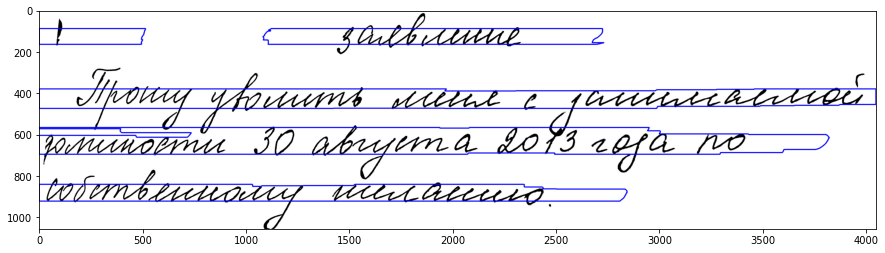

In [169]:
cv2.drawContours(image, contours, -1, (0,0,255), 3, cv2.LINE_AA, hierarchy, 1 )
plt.figure (figsize = (15, 20))
plt.imshow(image)
plt.show()

TypeError: Invalid shape (1200,) for image data

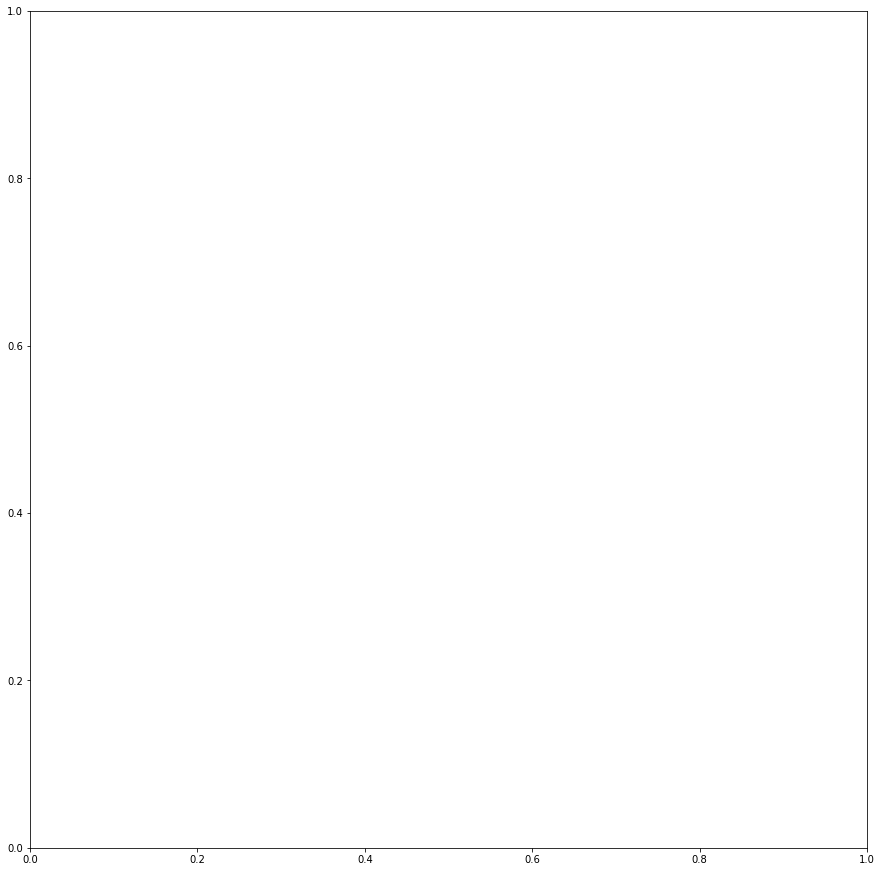

In [23]:
img_1 = np.zeros([1200,4200,1],dtype=np.uint8)
img_1.fill(255)

cv2.drawContours(img_1, contours, -1, (0,0,255), 3, cv2.LINE_AA, hierarchy, 1 )
projection = img_1.sum(axis=1).sum(axis=1)
projection_smoothed = savgol_filter(projection, 70, 3)
projection_smoothed = savgol_filter(projection_smoothed, 140, 3)
peaks, _ = find_peaks(projection_smoothed, height=0)
img_with_lines = deepcopy(img)
for idx in peaks:
    cv2.line(img_with_lines, (0, idx), (img_with_lines.shape[1], idx), (255, 0, 0))

plt.figure (figsize = (15, 20))
plt.imshow(projection_smoothed)
plt.show()

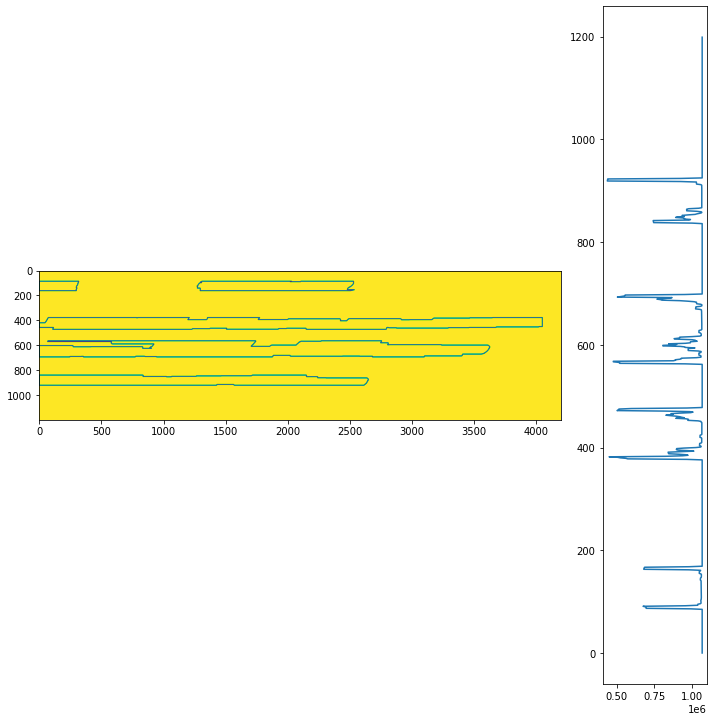

In [106]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()

ax[0].imshow(img_1)
projection = img_1.sum(axis=1).sum(axis=1)
ax[1].plot(projection,range(len(projection)))

In [133]:
range(len(projection))
projection

array([1071000, 1071000, 1071000, ..., 1071000, 1071000, 1071000],
      dtype=uint64)

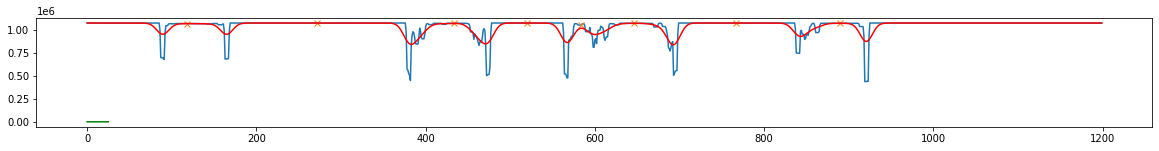

In [164]:
x = projection
xhat = gaussian_filter(x, sigma=7)
# xhat = savgol_filter(x, 50, 3)
# xhat = savgol_filter(xhat, 140, 3)
peaks, _ = find_peaks(xhat, height=0)
plt.figure(figsize=(20, 2))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(xhat, color='red')
plt.plot(idx_minimas, color='green')
plt.show()

In [146]:
from scipy.signal import argrelextrema

In [162]:
from scipy.ndimage.filters import gaussian_filter

/tmp/ipykernel_27631/2664825262.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [152]:
data = np.array(xhat)
idx_minimas = argrelextrema(data, np.less)[0]
idx_minimas

array([ 89, 129, 136, 163, 385, 407, 416, 425, 433, 436, 446, 468, 567,
       569, 601, 627, 641, 659, 667, 691, 846, 867, 874, 877, 891, 920])

In [76]:
projection = img_1.sum(axis=1).sum(axis=1)
projection, xhat

(array([1071000, 1071000, 1071000, ..., 1071000, 1071000, 1071000],
       dtype=uint64),
 array([1071000., 1071000., 1071000., ..., 1071000., 1071000., 1071000.]))

In [122]:
x[peaks]

array([1071000, 1071000, 1064855, 1064386, 1071000, 1071000, 1067981,
       1057107, 1068791, 1068791, 1071000, 1071000,  519842, 1049431,
        808253, 1068165, 1068610, 1068314, 1067804, 1067783, 1071000,
       1071000, 1068632, 1068536, 1071000], dtype=uint64)

In [194]:
def test(FILE_NAME: str):
    bboxes = get_bboxes(FILE_NAME)

    max_x = max([bbox[2] for bbox in bboxes])
    min_x = min([bbox[0] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    img = cv2.imread(FILE_NAME)

    img = img[min_y:max_y, min_x:max_x]
    image = binarize(img)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,3))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)
    
    kernel = np.ones((3,2),np.uint8)
    erosion = cv2.erode(thresh,kernel,iterations = 2)
    
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
    
    for i in range(0,3):
        canny = cv2.Canny(closing,0,255)
        closing = closing - canny
        
    out_inv = cv2.threshold(closing, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    out1 = draw_white_space_between_lines(out_inv,0,10000,True)
    out1 =cv2.threshold(out1, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(60,1))
    dilation1 = cv2.dilate(out1,kernel,iterations=7)

    contours, hierarchy = cv2.findContours(dilation1.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    img_1 = np.zeros([image.shape[0],image.shape[1],1],dtype=np.uint8)
    img_1.fill(255)

    cv2.drawContours(img_1, contours, -1, (0,0,255), 3, cv2.LINE_AA, hierarchy, 1 )
    projection = img_1.sum(axis=1).sum(axis=1)
    
#     projection_smoothed = savgol_filter(projection, 70, 3)
#     projection_smoothed_1 = savgol_filter(projection_smoothed, 140, 3)
    projection_smoothed = gaussian_filter(projection, sigma=7)
    
    img_with_lines = deepcopy(image)
    
#     mean_peaks = mean(projection_smoothed)
#     minimum = [i for i in peaks if i > mean_peaks] 
    
    minimum = argrelextrema(projection_smoothed, np.less)[0]
    
    for idx in minimum:
        cv2.line(img_with_lines, (0, idx), (img_with_lines.shape[1], idx), (255, 0, 0))
#     print(minimum)
    
    fig, ax = plt.subplots(2, 1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[0].imshow(img_with_lines)
    # ax.axis('off')
    ax[1].plot(projection)
    ax[1].plot(projection_smoothed, color='red')
    
    return

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.2 µs


CPU times: user 15.3 s, sys: 2.04 s, total: 17.3 s
Wall time: 5.52 s


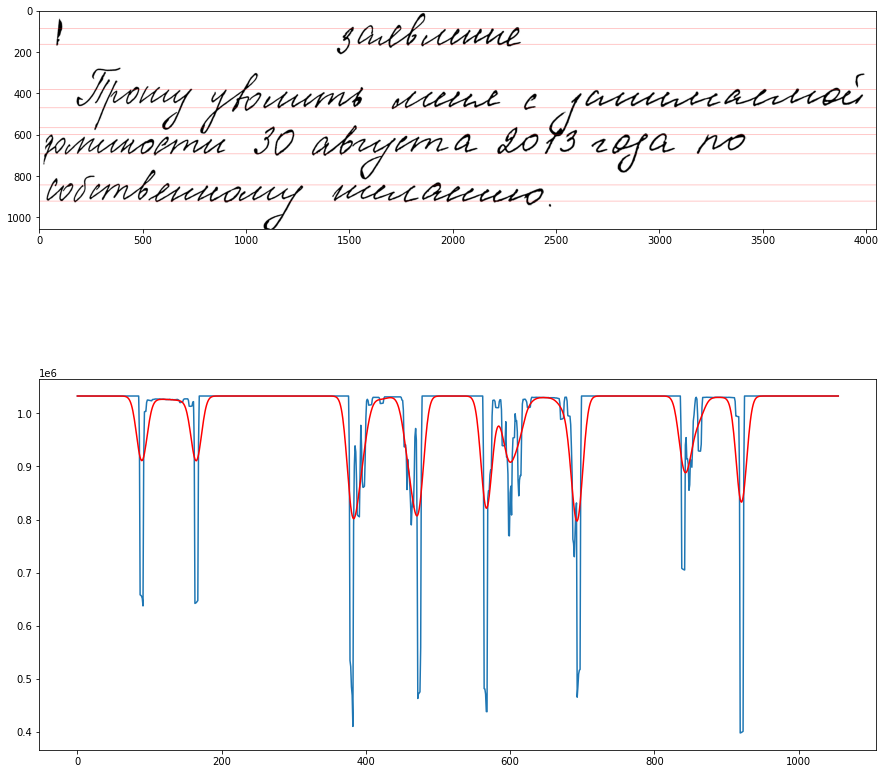

In [195]:
%%time
test('/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg')

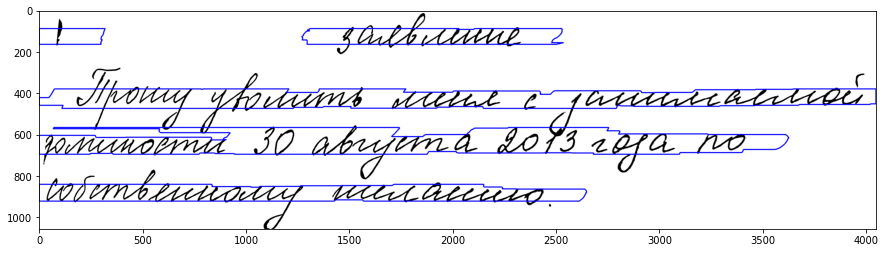

In [57]:
cv2.drawContours(image, contours, -1, (0,0,255), 3, cv2.LINE_AA)
plt.figure (figsize = (15, 20))
plt.imshow(image)
plt.show()

In [97]:
peaks = [15,  56, 121, 132, 197, 347, 414, 424, 429, 440, 506, 533, 564, 580, 598, 633, 636, 645, 656, 661, 727, 807, 874, 888, 953]

In [103]:
mean_peaks = mean(peaks)
minimum = [i for i in peaks if i > mean_peaks]
minimum

[533, 564, 580, 598, 633, 636, 645, 656, 661, 727, 807, 874, 888, 953]

In [177]:
import os
import time

In [178]:
timer = []
for i in range(10):
    start = time.time()
    test('/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg')
    end = time.time() - start
    timer.append(end)
    print(end)

3.9892821311950684
4.141752004623413
4.185730218887329
4.104845762252808
4.332176685333252
4.562471389770508
4.073240041732788
4.09978461265564
3.9461658000946045
3.9723927974700928


In [179]:
mean(timer)

4.14078414440155

In [181]:
timer_1 = []
for i in range(10):
    start = time.time()
    image, contours, hierarchy = test_0('/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg')
    end = time.time() - start
    timer_1.append(end)
    print(end)

4.113510370254517
3.9639458656311035
3.9947304725646973
4.062262773513794
4.0398101806640625
4.06070876121521
4.006462097167969
4.001814126968384
4.04620361328125
4.21341347694397


In [182]:
mean(timer_1)

4.050286173820496

In [ ]:
timer = []
for i in range(10):
    start = time.time()
    find_separators('/home/bekzat/Beka/project_docreader/lising_rotate/IMG_20220425_125447.jpg')
    end = time.time() - start
    timer.append(end)
    print(end)